# Search Engine Optimization

In [10]:
!pip install scikit-network

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sknetwork.ranking import PageRank
from warnings import filterwarnings

# Load node (URL) and edge (link) data
url = 'https://www.cs.cornell.edu/courses/cs685/2002fa/data/gr0.California'

num_nodes = 9664
edges = pd.read_table(url, sep='\s', header=None, skiprows=num_nodes,
                   usecols=[1, 2], names=['from', 'to'], engine='python')
num_edges = len(edges)
nodes = pd.read_table(url, sep='\s', header=None, skipfooter=num_edges,
                   usecols=[1, 2], names=['idx', 'url'], engine='python')

display(nodes)
display(edges)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 39.7 MB/s eta 0:00:00


,idx,url
0,0,http://www.berkeley.edu/
1,1,http://www.caltech.edu/
2,2,http://www.realestatenet.com/
3,3,http://www.ucsb.edu/
4,4,http://www.washingtonpost.com/wp-srv/national/...
...,...,...
9659,9659,http://www.spd.louisville.edu/~mejenn01/handy....
9660,9660,http://www.maxwellstreet.org/
9661,9661,http://village.ios.com/~internet/
9662,9662,http://www.meats.net/


,from,to
0,0,449
1,0,450
2,0,451
3,0,452
4,0,453
...,...,...
16145,9663,1806
16146,9663,266
16147,9663,7905
16148,9663,70


<BarContainer object of 11 artists>

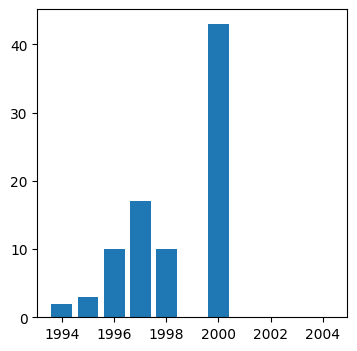

In [11]:
years = range(1994,2005)
counts = []
for year in years:
  counts.append(nodes['url'].str.contains(str(year)).sum())

plt.figure(figsize = (4,4))
plt.bar(years, counts)

# function to determine the positioning of Yahoo homepage in google search

In [12]:
# Suppress warnings about changing the sparsity structure of csr_matrix
filterwarnings("ignore", message="Changing the jsparsity structure.*")

# Convert edge list to adjacency matrix (sparse representation)
adjacency = csr_matrix((np.ones(len(edges)), (edges['from'], edges['to'])),
                       shape=(num_nodes, num_nodes), dtype=int)

def search_rank(target_url, adj_matrix):
  pagerank = PageRank()
  stationary_distribution = pagerank.fit_predict(adj_matrix)


  #convert to list
  list_url = nodes['url'].tolist()
  idx = list_url.index(target_url)
  prob_val = stationary_distribution[idx]
  descend = sorted (stationary_distribution, reverse = True)
  rank = descend.index(prob_val) + 1


  return rank

yahoo_home_url = "http://www.yahoo.com/"
print('Yahoo homepage search rank:', search_rank(yahoo_home_url, adjacency))

Yahoo homepage search rank: 22


# improving the search rank of Yahoo by backlinking

In [13]:
adj_backlinks = adjacency.copy()


def edit_backlinks(input, target):
  #convert to list
  list_url = nodes['url'].tolist()
  alias = []
  indexes = []
  for url in list_url:
    if input in url:
      alias.append(url)
  idx = alias.index(yahoo_home_url)
  alias.pop(idx)

  for link in alias:
    idx = list_url.index(link)
    idx_target = list_url.index(target)
    adj_backlinks[idx, idx_target] = 1

  return adj_backlinks

adj_backlinks = edit_backlinks(".yahoo.", yahoo_home_url)


print('Yahoo homepage search rank with more backlinks:',
      search_rank(yahoo_home_url, adj_backlinks))

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Yahoo homepage search rank with more backlinks: 6


# obfuscating and link scuplting to other yahoo pages to attempt to improve google ranking 

In [14]:
adj_sculpting = adj_backlinks.copy()


def obfuscate(input, target):
  #convert to list
  list_url = nodes['url'].tolist()
  alias = []
  indexes = []
  for url in list_url:
    if input in url:
      alias.append(url)
  idx = alias.index(yahoo_home_url)
  alias.pop(idx)

  for link in alias:
    idx = list_url.index(link)
    idx_target = list_url.index(target)
    adj_sculpting[idx, :idx_target] = 0
    adj_sculpting[idx, idx_target] = 1
    adj_sculpting[idx, idx_target+1:] = 0

  return adj_sculpting

adj_sculpting = obfuscate(".yahoo.", yahoo_home_url)


print('Yahoo homepage search rank with link sculpting:',
      search_rank(yahoo_home_url, adj_sculpting))

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Yahoo homepage search rank with link sculpting: 3


# implementing countermeasures that Google might take for obfuscation and link sculpting

In [15]:
adj_penalty = adj_sculpting.copy()


def reverse(input, target):
  #convert to list
  list_url = nodes['url'].tolist()
  alias = []
  indexes = []
  for url in list_url:
    if input in url:
      alias.append(url)
  idx = alias.index(yahoo_home_url)
  alias.pop(idx)

  for link in alias:
    idx = list_url.index(link)
    idx_target = list_url.index(target)
    adj_penalty[idx, idx_target] = 0

  return adj_penalty

adj_penalty = reverse(".yahoo.", yahoo_home_url)


print('Yahoo homepage search rank after Google penalty:',
      search_rank(yahoo_home_url, adj_penalty))

Yahoo homepage search rank after Google penalty: 33


# implementing potential Yahoo's strategy to improve the PageRank by using linkexchange

In [16]:
link_exch_home_url = "http://www.linkexchange.com/"
adj_buy_link = adj_penalty.copy()


def ad(input, target):
  #convert to list
  list_url = nodes['url'].tolist()
  alias = []
  indexes = []
  for url in list_url:
    if input in url:
      alias.append(url)
  #idx = alias.index(yahoo_home_url)
  #alias.pop(idx)

  for link in alias:
    idx = list_url.index(link)
    idx_target = list_url.index(target)
    adj_buy_link[idx, idx_target] = 1

  return adj_buy_link

adj_buy_link = ad(link_exch_home_url, yahoo_home_url)


print('Yahoo homepage search rank after buying link:',
      search_rank(yahoo_home_url, adj_buy_link))

Yahoo homepage search rank after buying link: 10


# further improving the ranking by linking back to the linkexchange

In [17]:
adj_link_back = adj_buy_link.copy()


def link_back(input, target):
  #convert to list
  list_url = nodes['url'].tolist()
  alias = []
  indexes = []
  for url in list_url:
    if input in url:
      alias.append(url)
  for link in alias:
    idx = list_url.index(link)
    idx_target = list_url.index(target)
    adj_link_back[idx_target, idx] = 1

  return adj_link_back

adj_link_back = link_back(link_exch_home_url, yahoo_home_url)


print('Yahoo homepage search rank after linking back:',
      search_rank(yahoo_home_url, adj_link_back))

Yahoo homepage search rank after linking back: 1
